# 오토 인코더
- 오토인코더는 어떤 감독 없이도 입력 데이터의 효율적인 표현인 코딩을 학습할 수 있는 인공 신경망
    - 코딩은 어떤 제약 조건 하에서 항등 함수를 학습하려는 오토인코더의 노력으로 생겨난 부산물
- 코딩은 일반적으로 입력보다 훨씬 낮은 차원을 가지므로 오토인코더가 차원 축소에 유용하게 사용됨
- 더 중요한 점은 강력한 특성 추출기처럼 작동하여 심층 신경망의 비지도 사전훈련에 사용될 수 있음
- 또한, 훈련 데이터와 매우 비슷한 새로운 데이터를 생성할 수 있음(이를 생성 모델이라고 함)

In [1]:
# 공통
import numpy as np
import os
import sys

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# 28*28 흑백 이미지를 그리기 위한 유틸리티 함수
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

# 여러 이미지를 그리기 위한 함수
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # 최소값을 0으로 만들어 패딩이 하얗게 보이도록 합니다.
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

## 15.1 효율적인 데이터 표현
- 오토인코더는 입력을 내부 표현으로 바꾸는 인코더(또는 인지네트워크)와 내부 표현을 출력으로 바꾸는 디코더(또는 생성 네트워크)로 구성됨
- 오토인코더가 입력을 재구성하므로 출력을 종종 재구성이라 부르고 비용 함수는 재구성과 입력이 다를 때 모델에 벌점을 부과하는 재구성 손실을 포함함
- 내부 표현이 입력 데이터보다 저차원이기 때문에 오토인코더를 과소완전이라고 함

## 15.2 과소완전 선형 오토인코더로 PCA 수행하기
- 오토인코더가 선형 활성화 함수만 사용하고 비용 함수가 평균 제곱 오차(MSE)라면, 이는 결국 주성분 분석(PCA)을 수행하는 것으로 볼 수 있음

In [3]:
# 3D 데이터셋 생성
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [4]:
# 3D 데이터셋 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [5]:
# 오토인코더 생성
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2  # 코딩 유닛
n_outputs = n_inputs # 출력 개수와 입력 개수가 동일

learning_rate = 0.01

# 단순한 PCA 수행을 위해 활성화 함수를 사용하지 않음(즉, 모든 뉴런이 선형)
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # 비용함수는 MSE

optimizer = tf.train.AdamOptimizer(learning_rate) # Adam 옵티마이저 사용
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [6]:
n_iterations = 1000
codings = hidden # 코딩을 만드는 은닉층을 출력

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train}) # 레이블이 없음 -> 비지도 학습
    codings_val = codings.eval(feed_dict={X: X_test})

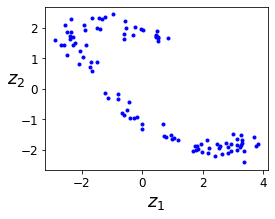

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show() # 오토인코더는 데이터에 있는 분산이 가능한 많이 보존되도록 투영할 최상의 2D 평면을 찾음(PCA와 동일)

## 15.3 적층 오토인코더
- 오토인코더도 여러 개의 은닉층을 가질 수 있는데 이를 적층 오토인코더(또는 심층 오토인코더)라고 함
- 층을 추가하면 더 복잡한 코딩을 학습할 수 있지만, 오토인코더가 너무 강력하게 되지 않도록 주의해야 함
    - 너무 강력한 오토인코더는 훈련 데이터를 완벽하게 재구성하겠지만 이 과정에서 유용한 데이터 표현을 학습하지 못할 것(또한, 일반화 힘듬)
- 적층 오토인코더의 구조는 전혁적으로 가운데 은닉층(코딩층)을 기준으로 대칭(책 p.526)

In [8]:
# MNIST 데이터 로드
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [9]:
# 셔플 함수
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

#### 15.3.1 텐서플로 구현
- 3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더 생성(ELU 활성화 함수와 He 초기화, L2 정규화)

In [10]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1 # 가운데 은닉층을 구조로 대칭
n_outputs = n_inputs # 가운데 은닉층을 구조로 대칭

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.variance_scaling_initializer() # He 초기화
#아래와 동일합니다:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=he_init, kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None) # 활성화 함수 없음

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate) # Adam 옵티마이저
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [11]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch}) # 비지도 학습
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch}) # 비지도 학습
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./my_model_all_layers.ckpt")

09% 훈련 MSE: 0.021005029
19% 훈련 MSE: 0.011436817
29% 훈련 MSE: 0.011802275
39% 훈련 MSE: 0.011764231
49% 훈련 MSE: 0.01169861


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


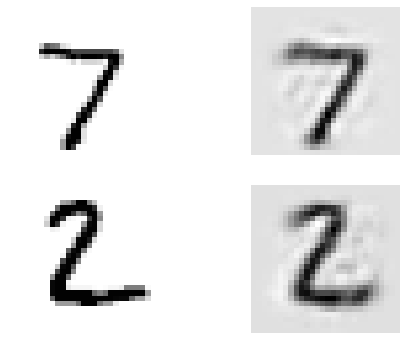

In [12]:
# 모델을 로드하고 테스트 세트에서 이를 평가하고 원본 이미지와 재구성 이미지를 그리는 함수
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        # X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")

#### 15.3.2 가중치 묶기
- 오토인코더가 완벽한 대칭일 땐 일반적으로 디코더의 가중치와 인코더의 가중치를 묶음
    - 이렇게 하면 모델에 있는 가중치의 수를 절반으로 줄여서 훈련 속도를 높이고 과대적합을 방지함
    - 다만, 텐서플로에서 구현은 복잡하므로 직접 층을 정의하는 것이 더 쉬움

In [13]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [14]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # 가중치 묶기(가중치1의 전치)
weights4 = tf.transpose(weights1, name="weights4")  # 가중치 묶기(가중치2의 전치)

# 편향은 묶지도 않고 규제하지도 않음
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 훈련 MSE: 0.017812923
19% 훈련 MSE: 0.016506217
29% 훈련 MSE: 0.01810514
39% 훈련 MSE: 0.018025832
49% 훈련 MSE: 0.017612007


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


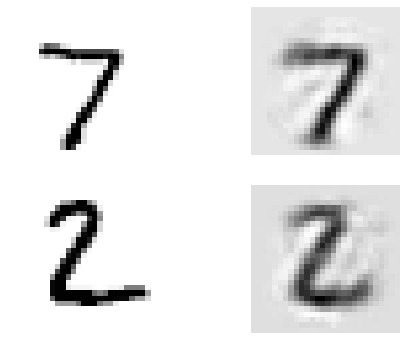

In [16]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

#### 15.2.3 한 번에 한 층씩 훈련하기
- 한 번에 전체 오토인코더를 훈련시키는 것보다 한 번에 오토인코더 하나를 훈련하고 이를 쌓아올려 한 개의 적층 오토인코더를 만드는 것이 더 빠름

##### 하나의 그래프에서 오토인코더를 따로따로 훈련하기

In [17]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # hidden2와 hidden3 통과합니다
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # hidden1 동결
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = len(X_train) // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_sizes[phase]))
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
    print("테스트 MSE:", loss_test)

훈련 단계 #1
09% 훈련 MSE: 0.007932796
19% 훈련 MSE: 0.0073406147
29% 훈련 MSE: 0.007749695
3 훈련 MSE: 0.007719645
훈련 단계 #2
09% 훈련 MSE: 0.24961476
19% 훈련 MSE: 0.005592799
29% 훈련 MSE: 0.0029503654
3 훈련 MSE: 0.0023403305
테스트 MSE: 0.009832288


##### 동결 층의 출력을 캐싱하기

In [19]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: X_train})
        for epoch in range(n_epochs[phase]):
            n_batches = len(X_train) // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(len(X_train))
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_sizes[phase]))
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
    print("테스트 MSE:", loss_test)

훈련 단계 #1
09% 훈련 MSE: 0.008147025
19% 훈련 MSE: 0.007710265
29% 훈련 MSE: 0.007226933
39% 훈련 MSE: 0.007944853
훈련 단계 #2
0 훈련 MSE: 0.3619457
19% 훈련 MSE: 0.006168533
29% 훈련 MSE: 0.002695943
3 훈련 MSE: 0.002236235
테스트 MSE: 0.00980622


#### 15.3.4 재구성 시각화
- 오토인코더가 제대로 훈련되었는지 확인하는 한 가지 방법은 입력과 출력을 비교해보는 것
    - 이 둘이 매우 비슷해야 하고, 차이가 있다면 중요한 부분이 아니어야 함

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


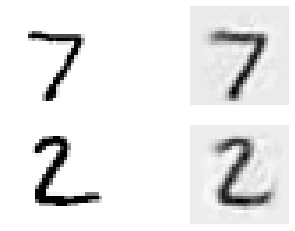

In [20]:
n_test_digits = 2
# X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index]) # 결과는 매우 비슷해 보임

#### 15.3.5 특성 시각화
- 오토인코더가 어떤 특성을 학습했으므로 이를 확인해야 함
    - 가장 간단한 기법은 은닉층에 있는 각 뉴런을 가장 크게 활성화시키는 훈련 샘플을 찾는 것
        - 특히 이 방법은 최상단의 은닉층에 유용(비교적 큰 특성을 잡아내기 때문에 이를 포함한 샘플을 찾기 쉬움)
        - 하위층은 특성의 크기가 작고 추상적이므로 이런 기법이 잘 들어맞지 않음
    - 다른 기법으로는 첫 번째 은닉층에 있는 각 뉴런에 연결된 가중치를 픽셀의 강도로 하는 이미지를 만들 수 있음

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


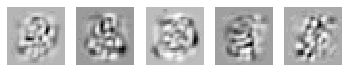

In [21]:
# 첫 번째 은닉층에서 다섯 개 뉴런에서 학습한 특성을 그림
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt")
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

plt.show() # 그림은 저수준 특성을 얻음

- 또 다른 기법은 랜덤한 입력 이미지를 오토 인코더에 주입하고, 관심 있는 뉴런의 활성화를 관찰하여 이 뉴런이 더 활성화되는 방향으로 이미지를 수정하도록 역전파를 수행하는 것(이를 여러 번 반복하면 이미지는 점차 놀라운 방향으로 바뀜)

## 15.4 적층 오토인코더를 사용한 비지도 사전 훈련
- 레이블되어 있는 훈련 데이터가 많지 않은 복잡한 지도 학습 문제를 다루어야 한다면, 한 가지 방법은 비슷한 문제에서 학습된 신경망을 찾아 하위층을 재사용하는 것
    - 이렇게 하면 저수준의 특성을 학습할 필요가 없기 때문에 적은 훈련 데이터만 사용해도 고성능 모델을 훈련시킬 수 있음
    - 즉, 기존의 네트워크에서 학습한 특성 감지 기능을 재사용하는 것

In [22]:
# MNIST 분류를 위한 작은 신경망 생성
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [23]:
# 사전 훈련 없이 평범하게 훈련
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = X_train[indices], y_train[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "검증 세트 정확도:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        test_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("테스트 정확도:", test_val)

09% 검증 세트 정확도: 0.93333334 테스트 정확도: 0.9191
1 검증 세트 정확도: 0.97333336 테스트 정확도: 0.9371
29% 검증 세트 정확도: 0.9866667 테스트 정확도: 0.9318
39% 검증 세트 정확도: 0.97333336 테스트 정확도: 0.9403


In [24]:
# 사전 훈련된 오토인코더의 첫 두개의 층을 재사용
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # layers 1와 2를 동결 (선택사항)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = X_train[indices], y_train[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "훈련 정확도:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        test_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("테스트 정확도:", test_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
09% 훈련 정확도: 0.9533333	테스트 정확도: 0.9273
19% 훈련 정확도: 0.94	테스트 정확도: 0.9401
2 훈련 정확도: 0.96666664	테스트 정확도: 0.9413
39% 훈련 정확도: 0.9866667	테스트 정확도: 0.938


## 15.5 잡음제거 오토인코더
- 오토인코더가 유용한 특성을 학습하도록 강제하는 다른 방법은 입력에 잡음을 추가하고, 노이즈가 없는 원본 입력을 복원하도록 훈련시키는 것
    - 이렇게 하면 오토인코더가 단순히 입력을 출력으로 복사하지 못하므로 데이터에 있는 패턴을 찾아야 함

#### 15.5.1 텐서플로 구현
- 가우시안 잡음과 드롭아웃 잡음을 사용

In [25]:
# 가우시안 잡음 사용
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [26]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 훈련 MSE: 0.04446056
19% 훈련 MSE: 0.038714346
29% 훈련 MSE: 0.043836817
39% 훈련 MSE: 0.042689517
49% 훈련 MSE: 0.04120454
59% 훈련 MSE: 0.041640867
69% 훈련 MSE: 0.042375557
79% 훈련 MSE: 0.040318266
89% 훈련 MSE: 0.043710943
99% 훈련 MSE: 0.042379368


In [27]:
# 드롭아웃 잡음 사용
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch, training: True}) # 훈련하는 동안은 True로 해야함
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

09% 훈련 MSE: 0.028069168
19% 훈련 MSE: 0.023578122
29% 훈련 MSE: 0.025170064
39% 훈련 MSE: 0.023552254
49% 훈련 MSE: 0.02383423
59% 훈련 MSE: 0.02311757
69% 훈련 MSE: 0.02342265
7 훈련 MSE: 0.02238668
89% 훈련 MSE: 0.02346741
99% 훈련 MSE: 0.023901047


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


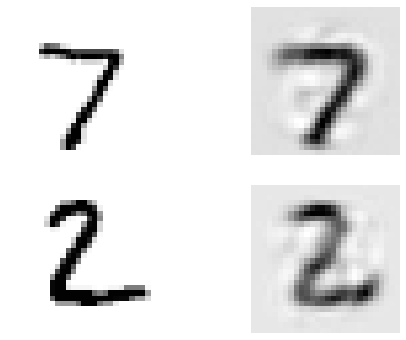

In [29]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

## 15.6 희소 오토인코더
- 좋은 특성을 추출하도록 만드는 다른 제약의 방식은 희소
    - 이는 비용 함수에 적절한 항을 추가하여 오토인코더가 코딩층에서 활성화되는 뉴런 수를 감소시키도록 만듬
    - 예를 들어 코딩층에서 평균적으로 5% 뉴런만 두드러지게 활성화되도록 강제할 수 있음
    - 적은 수의 뉴런만을 활용하여 입력을 표현해야 하므로 뉴런은 유용한 특성을 표현하게 됨
- 희소 모델을 만들기 위해 먼저 각 훈련 반복에서 코딩층의 실제 희소 정도를 측정해야 함(이때 배치 크기는 너무 작지 않아야 함)
- 각 뉴런에 대한 평균 활성화 정도를 알면 비용 함수에 희소 손실을 추가하여 뉴런이 너무 활성화되지 않도록 규제할 수 있음
    - 예를 들어 한 뉴런의 평균 활성화가 0.3이고 목표 희소 정도가 0.1이라면 이 뉴런은 덜 활성화되도록 규제되어야 함
    - 비용 함수에 제곱 오차를 추가할 수 있지만, 더 좋은 방법은 쿨러 라이블러 발산을 사용하는 것

[0, 1, 0, 0.95]

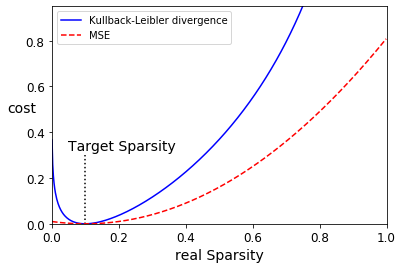

In [30]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target Sparsity", fontsize=14) # 목표 희소
plt.plot(q, kl_div, "b-", label="Kullback-Leibler divergence") # 쿨러 라이블러 발산
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("real Sparsity") # 실제 희소
plt.ylabel("cost", rotation=0) # 비용
plt.axis([0, 1, 0, 0.95])

#### 15.6.1 텐서플로 구현

In [31]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # 희소 코딩 유닛
n_outputs = n_inputs

# 쿨백 라이블러 발산 함수
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) 
# 코딩층의 활성화가 반드시 0과 1사이어야 함(아니면 KL 발산이 NAN을 반환하므로) 그래서 활성화 함수를 로지스틱으로 설정함
outputs = tf.layers.dense(hidden1, n_outputs)

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # 배치 평균
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [32]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", reconstruction_loss_val, "\t희소 손실:", sparsity_loss_val, "\t전체 손실:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

08% 훈련 MSE: 0.13764463 	희소 손실: 0.9086776 	전체 손실: 0.31938016
18% 훈련 MSE: 0.059780527 	희소 손실: 0.023853485 	전체 손실: 0.06455123
2 훈련 MSE: 0.052597467 	희소 손실: 0.028874451 	전체 손실: 0.058372356
3 훈련 MSE: 0.05017224 	희소 손실: 0.19674255 	전체 손실: 0.08952075
48% 훈련 MSE: 0.04457513 	희소 손실: 0.0070928843 	전체 손실: 0.045993704
5 훈련 MSE: 0.03982869 	희소 손실: 0.35642162 	전체 손실: 0.11111301
6 훈련 MSE: 0.03850078 	희소 손실: 0.0489216 	전체 손실: 0.048285097
7 훈련 MSE: 0.036211826 	희소 손실: 0.023476806 	전체 손실: 0.040907186
8 훈련 MSE: 0.033634786 	희소 손실: 0.057290047 	전체 손실: 0.045092795
9 훈련 MSE: 0.030880693 	희소 손실: 0.042790934 	전체 손실: 0.03943888
10 훈련 MSE: 0.028282983 	희소 손실: 0.32261822 	전체 손실: 0.09280663
11 훈련 MSE: 0.025015578 	희소 손실: 0.030909345 	전체 손실: 0.031197447
12 훈련 MSE: 0.023248762 	희소 손실: 0.08872007 	전체 손실: 0.040992774
13 훈련 MSE: 0.021769175 	희소 손실: 0.066300735 	전체 손실: 0.035029322
14% 훈련 MSE: 0.022006068 	희소 손실: 0.11473212 	전체 손실: 0.04495249
15% 훈련 MSE: 0.020363854 	희소 손실: 0.04796897 	전체 손실: 0.029957648
16% 훈련 MSE: 0.0

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


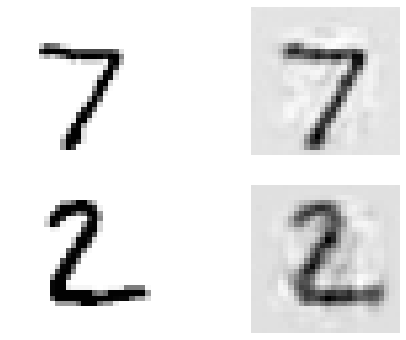

In [33]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

In [34]:
# 훈련 속도를 높이고 싶다면 비용함수로 MSE 대신 크로스엔트로피를 사용(예시)
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
# sigmoid_cross_entropy_with_logits ==> 출력에 로지스틱(시그모이드) 활성화 함수를 적용하고 크로스엔트로피를 계산함
reconstruction_loss = tf.reduce_mean(xentropy)

## 15.7 변이형 오토인코더
- 변이형 오토인코더는 가장 인기있는 오토인코더의 한 종류로 기존 오토인코더와는 다음이 다름
    - 확률적 오토인코더(즉, 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정됨)
    - 생성 오토인코더(마치 훈련 세트에서 샘플링된 것 같은 새로운 샘플을 생성할 수 있음)

In [35]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # 코딩 유닛
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.variance_scaling_initializer()

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

eps = 1e-10 # NaN을 반환하는 log(0)을 피하기 위한 안전항
latent_loss = 0.5 * tf.reduce_sum(tf.square(hidden3_sigma) + tf.square(hidden3_mean) - 1 - tf.log(eps + tf.square(hidden3_sigma)))

loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 전체 손실:", loss_val, "\t재구성 손실:", reconstruction_loss_val, "\t잠재 손실:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

09% 훈련 전체 손실: 26522.484 	재구성 손실: 22048.158 	잠재 손실: 4474.325
19% 훈련 전체 손실: 30053.914 	재구성 손실: 25044.312 	잠재 손실: 5009.601
2 훈련 전체 손실: 26719.02 	재구성 손실: 20768.508 	잠재 손실: 5950.5127
39% 훈련 전체 손실: 22574.172 	재구성 손실: 19640.877 	잠재 손실: 2933.2954
49% 훈련 전체 손실: 22014.242 	재구성 손실: 18007.61 	잠재 손실: 4006.6333
59% 훈련 전체 손실: 18545.068 	재구성 손실: 15334.816 	잠재 손실: 3210.252
69% 훈련 전체 손실: 17214.39 	재구성 손실: 14051.636 	잠재 손실: 3162.7556
7 훈련 전체 손실: 16084.497 	재구성 손실: 12800.945 	잠재 손실: 3283.5518
89% 훈련 전체 손실: 16574.602 	재구성 손실: 13183.182 	잠재 손실: 3391.4202
9 훈련 전체 손실: 16607.076 	재구성 손실: 13171.383 	잠재 손실: 3435.6938
10% 훈련 전체 손실: 15642.261 	재구성 손실: 12361.354 	잠재 손실: 3280.907
11% 훈련 전체 손실: 16286.32 	재구성 손실: 12930.172 	잠재 손실: 3356.149
12 훈련 전체 손실: 16015.586 	재구성 손실: 12633.936 	잠재 손실: 3381.6504
13 훈련 전체 손실: 16084.544 	재구성 손실: 12724.547 	잠재 손실: 3359.997
14% 훈련 전체 손실: 15525.684 	재구성 손실: 12086.49 	잠재 손실: 3439.1938
15 훈련 전체 손실: 20030.01 	재구성 손실: 16783.746 	잠재 손실: 3246.2632
16% 훈련 전체 손실: 24489.844 	재구성 손실: 18909.484 	잠

#### 15.7.1 숫자 이미지 생성
- 변이형 오토인코더를 사용하여 숫자 샘플과 비슷한 이미지를 생성
    - 먼저 모델을 훈련시킴
    - 가우시안 분포에서 랜덤한 코딩을 샘플링
    - 이를 디코딩

In [37]:
# 모델을 훈련시켜 랜덤한 이미지를 생성
n_digits = 60
n_epochs = 25 # 책에는 50회이나 성능상 줄임
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "훈련 전체 손실:", loss_val, "\t재구성 손실:", reconstruction_loss_val, "\t잠재 손실:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

09% 훈련 전체 손실: 30543.488 	재구성 손실: 24243.07 	잠재 손실: 6300.4185
19% 훈련 전체 손실: 28191.766 	재구성 손실: 22102.416 	잠재 손실: 6089.349
29% 훈련 전체 손실: 29210.596 	재구성 손실: 24981.203 	잠재 손실: 4229.3926
39% 훈련 전체 손실: 23253.852 	재구성 손실: 18660.715 	잠재 손실: 4593.1377
49% 훈련 전체 손실: 23773.172 	재구성 손실: 18957.08 	잠재 손실: 4816.092
5 훈련 전체 손실: 22255.0 	재구성 손실: 18122.482 	잠재 손실: 4132.5186
69% 훈련 전체 손실: 27529.084 	재구성 손실: 20146.55 	잠재 손실: 7382.5337
7 훈련 전체 손실: 18846.43 	재구성 손실: 15715.377 	잠재 손실: 3131.0532
89% 훈련 전체 손실: 17477.883 	재구성 손실: 14485.09 	잠재 손실: 2992.792
99% 훈련 전체 손실: 16854.326 	재구성 손실: 13673.53 	잠재 손실: 3180.7952
10% 훈련 전체 손실: 16684.645 	재구성 손실: 13393.363 	잠재 손실: 3291.282
11% 훈련 전체 손실: 16567.861 	재구성 손실: 13159.91 	잠재 손실: 3407.9512
12% 훈련 전체 손실: 16368.593 	재구성 손실: 13032.8125 	잠재 손실: 3335.7803
13% 훈련 전체 손실: 17210.658 	재구성 손실: 13802.1 	잠재 손실: 3408.5579
14% 훈련 전체 손실: 16617.438 	재구성 손실: 13305.215 	잠재 손실: 3312.2224
15 훈련 전체 손실: 16444.24 	재구성 손실: 13156.761 	잠재 손실: 3287.4788
16 훈련 전체 손실: 16459.209 	재구성 손실: 13043.121 	잠

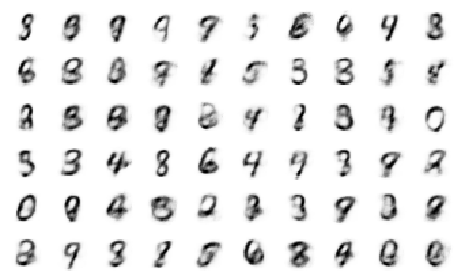

In [38]:
plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

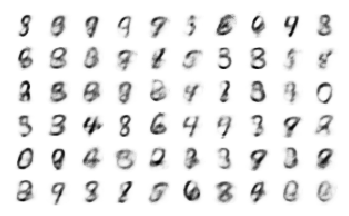

In [39]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
plt.show()

##### 인코드 및 디코드

In [40]:
# 인코드
n_digits = 3
# X_test, y_test = mnist.test.next_batch(batch_size)
X_test_batch, y_test_batch = next(shuffle_batch(X_test, y_test, batch_size))
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test_batch})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


In [41]:
# 디코드
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


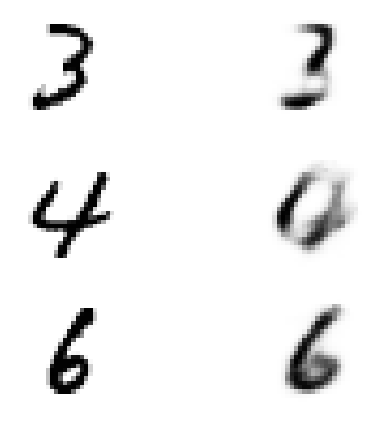

In [42]:
# 이미지 재구성
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test_batch[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

##### 숫자 이미지 보간

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


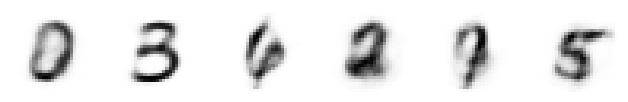

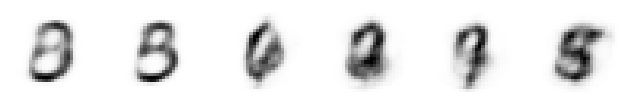

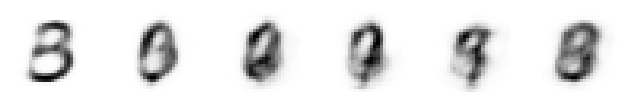

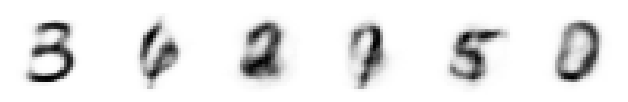

In [43]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()

## 15.8 다른 오토인코더들
- 수축 오토인코더(CAE)
    - 훈련하는 동안 입력에 대한 코딩의 변화율이 작도록 제약을 받음(두 개의 비슷한 입력은 비슷한 코딩이 되어야 함을 의미)
- 적층 합성곱 오토인코더
    - 합성곱 층을 통해 처리되는 이미지를 재구성함으로써 시각적 특징을 추출하는 법을 학습하는 오토인코더
- 확률적 생성 네트워크(GSN)
    - 데이터를 생성하는 기능을 추가한 잡음제거 오토인코더의 일반화된 모델
- WTA 오토인코더
    - 훈련하는 동안 코딩층에 있는 모든 뉴런의 활성화를 계산한 후 훈련 배치에서 각 뉴런에 대해 최대 k% 활성화만 보존하고 나머지는 0으로 설정
- 적대적 생성 네트워크(GAN)
    - '판별자'라고 부르는 네트워크가 '생성자'라고 부르는 두 번째 네트워가 만든 가짜 데이터와 실제 데이터를 구분하도록 훈련
    - 생성자는 판별자를 속이는 법을 학습하며, 판별자는 생성자의 속임수를 피하는 법을 학습하는 경쟁적 학습 방법

## 15.9 연습문제

#### 1. 오토인코더를 활용할 수 있는 주요 작업은 무엇인가요?
1. 특성 추출
2. 비지도 사전 훈련
3. 차원 축소
4. 생성 모델
5. 이상치 탐지(일반적으로 오토인코더는 이상치를 재구성하는 일은 잘하지 못함)

#### 2. 레이블되지 않은 훈련 데이터는 많지만, 레이블된 데이터는 수천 개 정도만 가지고 있을 때 분류기를 훈련시키려고 합니다. 오토인코더가 어떻게 도움이 될 수 있을까요? 어떻게 작업하면 될까요?
- 레이블되지 않은 훈련 데이터는 많지만, 레이블된 데이터는 수천 개 정도만 가지고 있을 때 분류기를 훈련시키려면 전체 데이터셋(레이블된 것 + 레이블되지 않은 것)에 먼저 심층 오토인코더를 훈련시킨 다음 하위층 절반(즉, 코딩층과 그 하위층들)을 재사용합니다. 그리고 레이블된 데이터를 사용해 분류기를 훈련시킵니다. 레이블된 데이터가 조금밖에 없다면 분류기를 훈련시킬 때 재사용된 층을 동결하는 것이 좋습니다.

#### 3. 오토인코더가 완벽하게 입력을 재구성했다면, 이것이 반드시 좋은 오토인코더인가요? 오토인코더의 성능을 어떻게 평가할 수 있나요?
- 어떤 인코더가 입력을 완벽하게 재구성한다는 사실이 반드시 좋은 오토인코더임을 의미하는 것은 아닙니다. 아마도 입력을 코딩층과 출력으로 복사하는 것을 배운 과대완전 오토인코더일지 모릅니다. 사실 코딩층의 뉴런이 한 개여도 매우 깊은 오토인코더는 모든 훈련 샘플을 다른 코딩으로 매핑하는 것이 가능합니다(예를 들어 첫 번째 샘플은 0.001에, 두 번째 샘플은 0.002에, 세 번째 샘플은 0.003에 매핑되는 식). 그리고 각 코딩에 대한 정확한 훈련 샘플을 재구성하는 것을 외워서 학습할 수 있습니다. 데이터에 있는 어떤 유용한 패턴을 실제 학습하지 않고 입력을 완벽히 재구성합니다. 실전에서 이런 매핑은 거의 일어나지 않지만 완벽하게 재구성되었다는 것이 오토인코더가 유용한 어떤 것을 학습했다고 보장하지 않는다는 사실을 말해줍니다. 하지만 재구성이 매우 나쁘다면 좋지 못한 오토인코더임이 거의 틀림없습니다. 오토인코더의 성능을 재기 위한 한 가지 방법은 재구성 손실을 계산하는 것입니다. 여기에서도 높은 재구성 손실을 오토인코더가 나쁘다는 것을 알려주는 좋은 신호입니다. 하지만 재구성 손실이 낮다고 해서 좋은 오토인코더임을 보장할 수는 없습니다. 사용하는 방식에 맞추어 오토인코더를 평가해야 합니다. 예를 들어 분류기의 비지도 사전훈련을 위해 사용한다면 분류기의 성능도 반드시 평가해야 합니다.

#### 4. 과소완전과 과대완전 오토인코더가 무엇인가요? 지나치게 과소완전인 오토인코더의 주요한 위험은 무엇인가요? 과대완전 오토인코더의 주요한 위험은 무엇인가요?
- 과소완전 오토인코더는 코딩층이 입력층과 출력층보다 작은 경우입니다. 만약 코딩층이 더 크다면 과대완전 오토인코더입니다. 아주 심한 과소완전 오토인코더는 입력을 재구성하는 데 실패할 가능성이 큽니다. 관대 완전 오토인코더의 주된 문제는 유용한 특성을 학습하지 못하고 입력을 출력으로 그냥 복사하는 것입니다.

#### 5. 적층 오토인코더에서 가중치를 어떻게 묶나요? 이렇게 하는 이유는 무엇인가요?
- 인코더 층의 가중치를 그에 상응하는 디코더 층과 묶으려면 인코더 가중치의 전치를 디코더의 가중치로 사용하면 됩니다. 이렇게 하면 모델의 파라미터 개수가 반으로 줄고, 종종 적은 훈련 데이터로도 수렴이 빨라집니다. 또한 훈련 세트에 과대적합될 위험을 감소시킵니다.

#### 6. 적층 오토인코더의 하위층에서 학습한 특성을 시각화하기 위해 사용하는 일반적인 기법은 무엇인가요? 상위층에 대해서는 어떻게 할 수 있나요?
- 스택 오토인코더의 하위층이 학습한 특성을 시각화하기 위한 일반적인 방법은 각 뉴런의 가중치를 입력 이미지의 크기로 바꾸어 그려보는 것입니다. 상위층에서 학습한 특성을 시각화하기 위한 한 가지 방법은 각 뉴런을 가장 활성화시키는 훈련 샘플을 그려보는 것입니다.

#### 7. 생성 모델이 무엇인가요? 생성 오토인코더의 종류를 나열해보세요.
- 생성 모델은 훈련 샘플과 닮은 출력을 랜덤하게 생성할 수 있는 모델입니다. 예를 들어 MNIST 데이터셋에 잘 훈련된 생성 모델은 실제와 같은 임의의 숫자 이미지를 생성할 수 있습니다. 출력 분포는 일반적으로 훈련 데이터와 비슷합니다. 예를 들어 MNIST에는 각 숫자별 이미지가 많기 때문에 이 생성 모델은 각 숫자에 대해 거의 비슷한 개수의 이미지를 출력할 것입니다. 어떤 생성 모델은 특정 종류의 출력만 생성하기 윟 파라미터로 제어할 수 있습니다. 변이형 오토인코더가 생성 오토인코더의 한 예입니다.